In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import glob, os
from sdt_dask.clients.azure.azure import Azure
from sdt_dask.dataplugs.pvdaq_plug import PVDAQPlug
from sdt_dask.dataplugs.pvdb_plug import PVDBPlug
from sdt_dask.dataplugs.csv_plug import LocalFiles
from sdt_dask.dataplugs.S3Bucket_plug import S3Bucket
from sdt_dask.dask_tool.runner import Runner

# Import user-defined dataplug

## Pull from PVDAQ

In [3]:
PVDAQPlug?

Init signature: PVDAQPlug(api_key='DEMO_KEY', power_col='ac_power')
Docstring:     
Dataplug class for retrieving data from the PVDAQ DB.
Note that the DEMO_KEY has a rate limit of 30/h, 50/d per IP address.
File:           ~/Desktop/SLAC_clone/solar-data-tools/sdt_dask/dataplugs/pvdaq_plug.py
Type:           type
Subclasses:     

In [22]:
pvdaq_data_plug = PVDAQPlug()

In [24]:
KEYS = [(34, 2011), (35, 2015), (51,2012)] # site ID and year pairs
pvdaq_data_plug.get_data(KEYS[0])

[============================================================] 100.0% ...queries complete in 1.7 seconds       



,ac_power
2011-01-01 00:00:00,-200.0
2011-01-01 00:15:00,-300.0
2011-01-01 00:30:00,-300.0
2011-01-01 00:45:00,-200.0
2011-01-01 01:00:00,-300.0
...,...
2011-12-31 22:45:00,-300.0
2011-12-31 23:00:00,-200.0
2011-12-31 23:15:00,-200.0
2011-12-31 23:30:00,-200.0


## Pull from redshift database

In [25]:
PVDBPlug?

Init signature: PVDBPlug(power_col='meas_val_f')
Docstring:      Dataplug class for retrieving data from the PVDB (Redshift) database.
File:           ~/Desktop/SLAC_clone/solar-data-tools/sdt_dask/dataplugs/pvdb_plug.py
Type:           type
Subclasses:     

In [ ]:
redshift_data_plug = PVDBPlug()

KEYS = [("TABJC1027159", 0), ("TAAI01129193", 0)]

redshift_data_plug.get_data(KEYS[0])

## Pull from local csv files is not suppprted for Azure client

## Pull from S3Bucket

In [31]:
S3Bucket?

Init signature: S3Bucket(bucket_name)
Docstring:     
Dataplug class for retrieving data from an S3 bucket.
aws configurations for the AWS CLI must be set up in local environment
Init docstring:
Initialize the S3Bucket object with the bucket name.

:param bucket_name: The name of the S3 bucket to pull data from
File:           ~/Desktop/SLAC_clone/solar-data-tools/sdt_dask/dataplugs/S3Bucket_plug.py
Type:           type
Subclasses:     

In [20]:
bucket_name = "pvinsight-dask-baseline"
s3_data_plug = S3Bucket(bucket_name)
KEYS = s3_data_plug._pull_keys()
KEYS = [(key,) for key in KEYS]
s3_data_plug.get_data((KEYS[0],))

/Users/liuhaoyang/Desktop/SLAC_clone/solar-data-tools/solardatatools/time_axis_manipulation.py:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  meas_name = str(df_view[name_key][0])


,ac_power_01
ts,
2017-09-13 06:22:32,0.0
2017-09-13 06:37:32,18.0
2017-09-13 06:52:32,53.0
2017-09-13 07:07:35,70.0
2017-09-13 07:22:34,136.0
...,...
2018-10-12 16:51:04,217.0
2018-10-12 17:06:04,131.0
2018-10-12 17:21:04,54.0


# Initialize the Client

In [6]:
worker_options = {
    "nthreads": 2,
    "memory_limit": "15.63GiB" # using the maximum memory limit for Azure VM
}
client_setup = Azure(
    resource_group="pvinsight-dask",
    vnet="dask-vnet",
    security_group="pvinsight-dask",
    n_workers=1,
    worker_options=worker_options,
    docker_image="nimishy/sdt-cloud-win:latest"
)
# Dask Local Client Initialization
client = client_setup.init_client()

[i] Initializing Azure VM Cluster ...
[i] Worker Options: {'nthreads': 2, 'memory_limit': '15.63GiB'}
Creating scheduler instance
Assigned public IP
Network interface ready
Creating VM
Created VM dask-583a56ea-scheduler
Waiting for scheduler to run at 52.137.64.142:8786
Scheduler is running


/Users/liuhaoyang/anaconda3/envs/SLAC/lib/python3.10/contextlib.py:142: UserWarning: Creating your cluster is taking a surprisingly long time. This is likely due to pending resources. Hang tight! 
  next(self.gen)


Creating worker instance
Network interface ready
Creating VM
Created VM dask-583a56ea-worker-6accec5e
[i] Initialized Azure VM Cluster
[i] Initializing Dask Client ...
[>] Dask Dashboard: http://52.137.64.142:8787/status


# Use Runner to take in data plug and cluster then run the Dask tasks


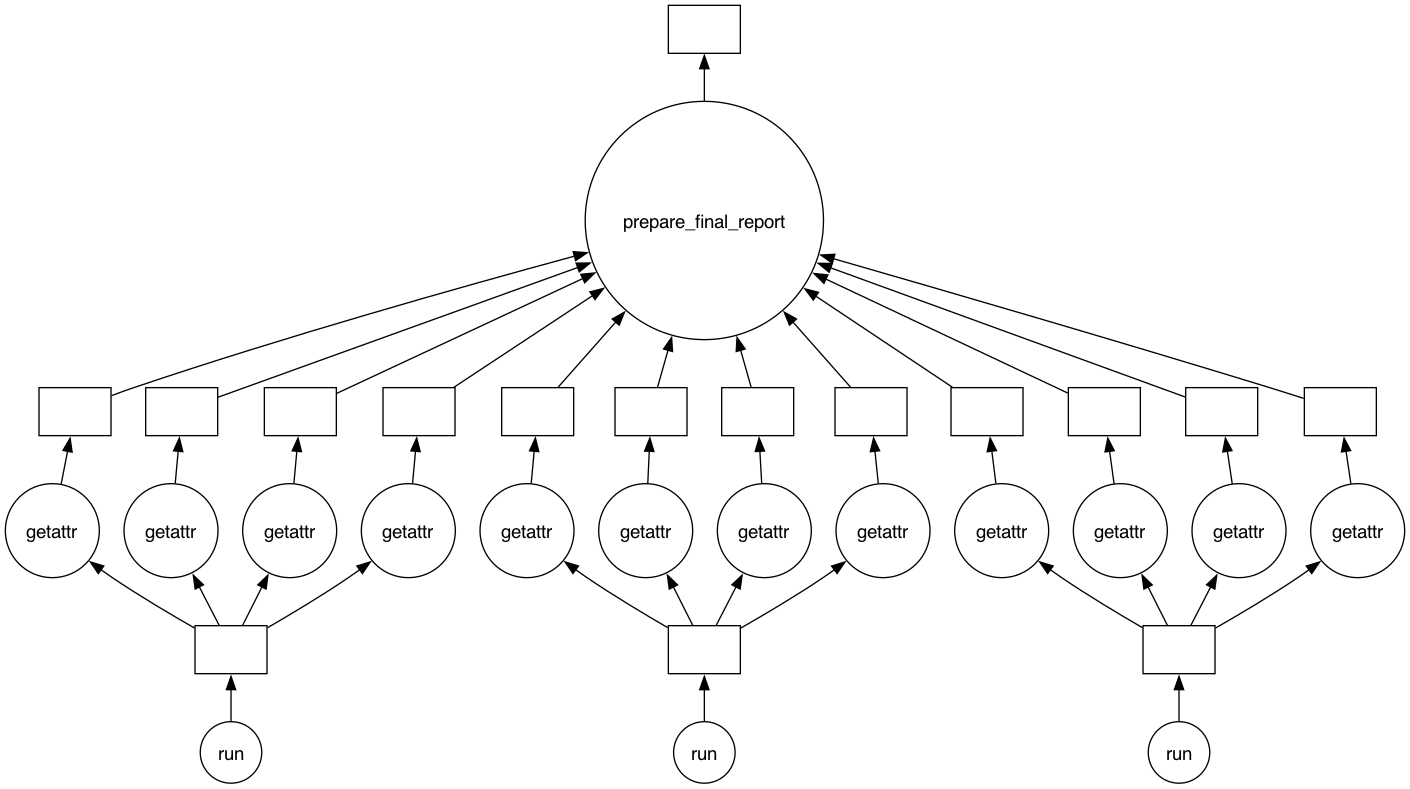

In [10]:
runner = Runner(data_plug=pvdaq_data_plug, # change to csv_data_plug, redshift_data_plug, or s3_data_plug as needed
                client=client,
                output_path=f"../result/")

runner.set_up(KEYS, fix_shifts=True, verbose=True)
runner.visualize()

from IPython.display import display, Image
display(Image(filename='sdt_graph.png'))


# Get final result table

In [12]:
runner.get_result()

# The result table and dask report has been saved in the folder you specified in the output_path parameter of the Runner object,
# you could check it out

Terminated VM dask-583a56ea-worker-6accec5e
Removed disks for VM dask-583a56ea-worker-6accec5e
Deleted network interface
Terminated VM dask-583a56ea-scheduler
Removed disks for VM dask-583a56ea-scheduler
Deleted network interface
Unassigned public IP
